In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
missing_ratio = train.isnull().mean()
columns_to_drop = missing_ratio[missing_ratio > 0.8].index.tolist()

train = train.drop(columns=columns_to_drop, axis=1)
test = test.drop(columns=columns_to_drop, axis=1)

train.head(2)

,ID,generation,school1,major type,major1_1,major1_2,major_data,job,class1,re_registration,...,incumbents_level,incumbents_lecture,incumbents_company_level,incumbents_lecture_type,incumbents_lecture_scale,incumbents_lecture_scale_reason,interested_company,expected_domain,onedayclass_topic,withdrawal
0,TRAIN_0000,8,3e0057be3ecde495d1d6aab0bdc3092cce94440a6a4f68...,단일 전공,IT(컴퓨터 공학 포함),NaN,False,대학생,4,아니요,...,주니어 (0~3년차),커리어 패스 과정 (예시: 비전공자/전공자의 취업 준비 및 이직 과정),"국내 대기업 IT 계열 (금융, 제조 ...)","온,오프라인 동시",3~50명 내외의 강의 리스너와 1명의 현직자,인원이 너무 많지 않아야 편하게 들을 수 있어서,삼성이나 하이닉스,AI,C++ 응용,1
1,TRAIN_0001,8,c7c76d1a4c9d719d17c899a3ca9de153452a22163fe083...,"복수 전공 ( 다중전공, 이중전공 포함 )",IT(컴퓨터 공학 포함),IT(컴퓨터 공학 포함),False,대학생,4,아니요,...,주니어 (0~3년차),직무 강의 (예시: 실무 진행 방식 및 직무 준비생을 위한 팁),국내 빅테크 IT 계열 (네카쿠라배당토),"온,오프라인 동시",10명 내외의 강의 리스너와 1명의 현직자,인원이 적어야 집중할 수 있고 질문 하기 쉽다.,네이버,AI,.,1


In [4]:
train2 = train.drop(["major1_1","major1_2","generation","school1","class1","onedayclass_topic","incumbents_lecture_scale_reason","interested_company"],axis=1)

In [5]:
# 1. NaN 처리
train2['major_field'] = train2['major_field'].fillna('')

# 2. 전공 분리
split_majors = train2['major_field'].apply(
    lambda x: [m.strip() for m in x.split(',') if m.strip() != '']
)

# 3. 전공을 공학/IT/기타로 매핑
def map_major(majors):
    mapped = []
    for major in majors:
        if major == '공학 (컴퓨터 공학 제외)':
            mapped.append('major_field_공학 (컴퓨터 공학 제외)')
        elif major == 'IT (컴퓨터 공학 포함)':
            mapped.append('major_field_IT (컴퓨터 공학 포함)')
        else:
            mapped.append('major_field_기타')
    return list(set(mapped))  # 중복 제거

mapped_majors = split_majors.apply(map_major)

# 4. 멀티라벨 원핫 인코딩
mlb = MultiLabelBinarizer()
encoded_major = pd.DataFrame(
    mlb.fit_transform(mapped_majors),
    columns=mlb.classes_,
    index=train2.index
)

# 5. 원본과 결합
train2 = pd.concat([train2, encoded_major], axis=1)

In [6]:
def classify_job(text):
    if pd.isna(text):
        return '기타/미정'
    
    text = str(text).lower().strip()
    
    job_keywords = {
        '데이터': ['데이터', '분석', 'ai', '인공지능', '머신러닝', 'ml', '딥러닝', 'nlp'],
        '개발/IT': ['개발', '전산', 'it', '소프트웨어', 'db', '보안', '프로그래밍'],
        '엔지니어링': ['엔지니어', '반도체', '공정', '설계', '품질', '기계', '화학', '설비'],
        '연구직': ['연구자', '연구원', '대학원'],
        '금융/회계': ['계리', '퀀트', '회계', '금융', '펀드', '재무', '리서치', '애널리스트'],
        '기획/PM': ['pm', '기획', '컨설팅', '컨설턴트', 'operation', '서비스 기획'],
        '마케팅/영업': ['마케터', '영업', '해외영업', '퍼포먼스', 'md', '마케팅']
    }

    for category, keywords in job_keywords.items():
        for keyword in keywords:
            if keyword in text:
                return category
    
    return '기타/미정'

In [7]:
train2['job_group'] = train2['desired_job'].apply(classify_job)

In [8]:
train2["job_group"].unique()

array(['데이터', '기타/미정', '개발/IT', '연구직', '금융/회계', '기획/PM', '마케팅/영업',
       '엔지니어링'], dtype=object)

In [9]:
train2.head()

,ID,major type,major_data,job,re_registration,nationality,inflow_route,whyBDA,what_to_gain,hope_for_group,...,incumbents_lecture,incumbents_company_level,incumbents_lecture_type,incumbents_lecture_scale,expected_domain,withdrawal,major_field_IT (컴퓨터 공학 포함),major_field_공학 (컴퓨터 공학 제외),major_field_기타,job_group
0,TRAIN_0000,단일 전공,False,대학생,아니요,내국인,에브리타임,"BDA 학회원만의 혜택을 누리고 싶어서(현직자 강연, 잡 페스티벌, 기업연계 공모전 등)",프로젝트 경험,네. 오프라인으로 참여하고 싶어요,...,커리어 패스 과정 (예시: 비전공자/전공자의 취업 준비 및 이직 과정),"국내 대기업 IT 계열 (금융, 제조 ...)","온,오프라인 동시",3~50명 내외의 강의 리스너와 1명의 현직자,AI,1,0,1,0,데이터
1,TRAIN_0001,"복수 전공 ( 다중전공, 이중전공 포함 )",False,대학생,아니요,내국인,에브리타임,혼자 공부하기 어려워서,프로젝트 경험,네. 오프라인으로 참여하고 싶어요,...,직무 강의 (예시: 실무 진행 방식 및 직무 준비생을 위한 팁),국내 빅테크 IT 계열 (네카쿠라배당토),"온,오프라인 동시",10명 내외의 강의 리스너와 1명의 현직자,AI,1,1,0,0,데이터
2,TRAIN_0002,단일 전공,True,대학생,아니요,내국인,에브리타임,혼자 공부하기 어려워서,데이터 분석 역량,네. 오프라인으로 참여하고 싶어요,...,커리어 패스 과정 (예시: 비전공자/전공자의 취업 준비 및 이직 과정),"국내 대기업 IT 계열 (금융, 제조 ...)","온,오프라인 동시",3~50명 내외의 강의 리스너와 1명의 현직자,AI,1,1,0,0,데이터
3,TRAIN_0003,단일 전공,True,대학생,아니요,내국인,에브리타임,현직자의 강의를 듣고 싶어서,데이터 분석 역량,네. 온라인으로 참여하고 싶어요,...,커리어 패스 과정 (예시: 비전공자/전공자의 취업 준비 및 이직 과정),국내 빅테크 IT 계열 (네카쿠라배당토),"온,오프라인 동시",3~50명 내외의 강의 리스너와 1명의 현직자,AI,0,0,0,1,데이터
4,TRAIN_0004,"복수 전공 ( 다중전공, 이중전공 포함 )",False,대학생,아니요,내국인,에브리타임,혼자 공부하기 어려워서,공모전 경험,네. 오프라인으로 참여하고 싶어요,...,커리어 패스 과정 (예시: 비전공자/전공자의 취업 준비 및 이직 과정),"국내 대기업 IT 계열 (금융, 제조 ...)",오프라인,100명 이상의 리스너와 10명 이상의 현직자,금융,1,1,0,1,데이터


In [10]:
# 자격증 키워드 리스트
cert_keywords = ['ADsP', 'SQLD', '빅데이터 분석 기사', '정보처리기사', '컴퓨터활용능력', '구글 애널리스트', '태블로', 'AWS']

# 결측값 처리
train2['certificate_acquisition'] = train2['certificate_acquisition'].fillna('')

# "준비중" 포함된 항목은 제외하고 인코딩
for cert in cert_keywords:
    train2[f'cert_{cert}'] = train2['certificate_acquisition'].apply(
        lambda x: 1 if (cert.lower() in x.lower() and '준비중' not in x) else 0
    )

In [11]:
train2.head()

,ID,major type,major_data,job,re_registration,nationality,inflow_route,whyBDA,what_to_gain,hope_for_group,...,major_field_기타,job_group,cert_ADsP,cert_SQLD,cert_빅데이터 분석 기사,cert_정보처리기사,cert_컴퓨터활용능력,cert_구글 애널리스트,cert_태블로,cert_AWS
0,TRAIN_0000,단일 전공,False,대학생,아니요,내국인,에브리타임,"BDA 학회원만의 혜택을 누리고 싶어서(현직자 강연, 잡 페스티벌, 기업연계 공모전 등)",프로젝트 경험,네. 오프라인으로 참여하고 싶어요,...,0,데이터,0,0,0,0,0,0,0,0
1,TRAIN_0001,"복수 전공 ( 다중전공, 이중전공 포함 )",False,대학생,아니요,내국인,에브리타임,혼자 공부하기 어려워서,프로젝트 경험,네. 오프라인으로 참여하고 싶어요,...,0,데이터,0,0,0,0,0,0,0,0
2,TRAIN_0002,단일 전공,True,대학생,아니요,내국인,에브리타임,혼자 공부하기 어려워서,데이터 분석 역량,네. 오프라인으로 참여하고 싶어요,...,0,데이터,0,0,0,0,0,0,0,0
3,TRAIN_0003,단일 전공,True,대학생,아니요,내국인,에브리타임,현직자의 강의를 듣고 싶어서,데이터 분석 역량,네. 온라인으로 참여하고 싶어요,...,1,데이터,0,0,0,0,1,0,0,0
4,TRAIN_0004,"복수 전공 ( 다중전공, 이중전공 포함 )",False,대학생,아니요,내국인,에브리타임,혼자 공부하기 어려워서,공모전 경험,네. 오프라인으로 참여하고 싶어요,...,1,데이터,0,1,0,0,0,0,0,0


In [12]:
train2.drop(["major_field","desired_job","certificate_acquisition","desired_certificate"], axis=1, inplace=True)

In [13]:
train2.head()

,ID,major type,major_data,job,re_registration,nationality,inflow_route,whyBDA,what_to_gain,hope_for_group,...,major_field_기타,job_group,cert_ADsP,cert_SQLD,cert_빅데이터 분석 기사,cert_정보처리기사,cert_컴퓨터활용능력,cert_구글 애널리스트,cert_태블로,cert_AWS
0,TRAIN_0000,단일 전공,False,대학생,아니요,내국인,에브리타임,"BDA 학회원만의 혜택을 누리고 싶어서(현직자 강연, 잡 페스티벌, 기업연계 공모전 등)",프로젝트 경험,네. 오프라인으로 참여하고 싶어요,...,0,데이터,0,0,0,0,0,0,0,0
1,TRAIN_0001,"복수 전공 ( 다중전공, 이중전공 포함 )",False,대학생,아니요,내국인,에브리타임,혼자 공부하기 어려워서,프로젝트 경험,네. 오프라인으로 참여하고 싶어요,...,0,데이터,0,0,0,0,0,0,0,0
2,TRAIN_0002,단일 전공,True,대학생,아니요,내국인,에브리타임,혼자 공부하기 어려워서,데이터 분석 역량,네. 오프라인으로 참여하고 싶어요,...,0,데이터,0,0,0,0,0,0,0,0
3,TRAIN_0003,단일 전공,True,대학생,아니요,내국인,에브리타임,현직자의 강의를 듣고 싶어서,데이터 분석 역량,네. 온라인으로 참여하고 싶어요,...,1,데이터,0,0,0,0,1,0,0,0
4,TRAIN_0004,"복수 전공 ( 다중전공, 이중전공 포함 )",False,대학생,아니요,내국인,에브리타임,혼자 공부하기 어려워서,공모전 경험,네. 오프라인으로 참여하고 싶어요,...,1,데이터,0,1,0,0,0,0,0,0


In [68]:
for col in train2.columns:
    print(f"컬럼명: {col}")
    print(train2[col].unique())

컬럼명: ID
['TRAIN_0000' 'TRAIN_0001' 'TRAIN_0002' ... 'TRAIN_1053' 'TRAIN_1054'
 'TRAIN_1055']
컬럼명: major type
['단일 전공' '복수 전공 ( 다중전공, 이중전공 포함 )' nan]
컬럼명: major_data
[False  True]
컬럼명: job
['대학생' '취준생' '직장인' '대학원생']
컬럼명: re_registration
['아니요' '예']
컬럼명: nationality
['내국인' '외국인']
컬럼명: inflow_route
['에브리타임' '기존 학회원 또는 운영진' '인스타그램' '대외활동 사이트(링커리어, 캠퍼스픽, 캠퍼즈, 위비티 등)'
 '지인 추천' '정보없음' '교내 플랫폼 (에브리타임 X)' '인터넷 검색' '기타']
컬럼명: whyBDA
['BDA 학회원만의 혜택을 누리고 싶어서(현직자 강연, 잡 페스티벌, 기업연계 공모전 등)' '혼자 공부하기 어려워서'
 '현직자의 강의를 듣고 싶어서' '학회 가입 시 코딩 테스트, 면접 등을 보지 않아서' '시간적으로 부담이 없어서'
 '이전 기수에 매우 만족해서' '큰 규모인 만큼, 커리큘럼이나 운영 등 관리가 잘 될것 같아서']
컬럼명: what_to_gain
['프로젝트 경험' '데이터 분석 역량' '공모전 경험' '인적 네트워크' nan '위 4항목 전부' '모두'
 '공모전, 프로젝트 경험 둘 다' '자격증 공부' '파이썬 실력']
컬럼명: hope_for_group
['네. 오프라인으로 참여하고 싶어요' '네. 온라인으로 참여하고 싶어요' '아니요. 개인적으로 학회 활동을 하고 싶어요' nan]
컬럼명: desired_career_path
['취업' '대학원 진학과 취업 중 고민' '대학원 진학' nan '미정' '창업' '아직 미정'
 '대학원진학과 취업 둘중 고민입니다.' '싸피' '대학원과 취업중 고민중입니다' '-' '취업 또는 대학원 진학' '재직중'
 '대학원 진학과 취업중에 하나를 

In [69]:
train2.nunique()

ID                            1056
major type                       2
major_data                       2
job                              4
re_registration                  2
nationality                      2
inflow_route                     9
whyBDA                           7
what_to_gain                     9
hope_for_group                   3
desired_career_path             27
completed_semester               2
project_type                     2
time_input                      18
certificate_study_period         2
desired_job_except_data         35
incumbents_level                 2
incumbents_lecture               8
incumbents_company_level        22
incumbents_lecture_type          3
incumbents_lecture_scale        11
expected_domain                 68
withdrawal                       2
major_field_IT (컴퓨터 공학 포함)       2
major_field_공학 (컴퓨터 공학 제외)       2
major_field_기타                   2
job_group                        8
cert_ADsP                        2
cert_SQLD           

In [71]:
train2.columns

Index(['ID', 'major type', 'major_data', 'job', 're_registration',
       'nationality', 'inflow_route', 'whyBDA', 'what_to_gain',
       'hope_for_group', 'desired_career_path', 'completed_semester',
       'project_type', 'time_input', 'certificate_study_period',
       'desired_job_except_data', 'incumbents_level', 'incumbents_lecture',
       'incumbents_company_level', 'incumbents_lecture_type',
       'incumbents_lecture_scale', 'expected_domain', 'withdrawal',
       'major_field_IT (컴퓨터 공학 포함)', 'major_field_공학 (컴퓨터 공학 제외)',
       'major_field_기타', 'job_group', 'cert_ADsP', 'cert_SQLD',
       'cert_빅데이터 분석 기사', 'cert_정보처리기사', 'cert_컴퓨터활용능력', 'cert_구글 애널리스트',
       'cert_태블로', 'cert_AWS'],
      dtype='object')

In [14]:
def map_career_group(value):
    if pd.isna(value):
        return '미정'

    value = str(value).lower()

    # 미정 조건: 고민, 미정, 혹은, 아직, 선택, 정해지지
    if any(keyword in value for keyword in ['고민', '미정', '혹은', '아직', '선택', '정해지']):
        return '미정'
    
    # 대학원 (고민 제외)
    elif '대학원' in value:
        return '대학원'

    # 취업 및 유사
    elif any(keyword in value for keyword in ['취업', '이직', '스타트업']):
        return '취업'

    # 기타
    elif any(keyword in value for keyword in ['편입', '고시', '싸피', '창업']):
        return '기타'

    # 그 외는 기타로 처리
    else:
        return '기타'
train2['career_path'] = train2['desired_career_path'].apply(map_career_group)

In [73]:
train2.head()

,ID,major type,major_data,job,re_registration,nationality,inflow_route,whyBDA,what_to_gain,hope_for_group,...,job_group,cert_ADsP,cert_SQLD,cert_빅데이터 분석 기사,cert_정보처리기사,cert_컴퓨터활용능력,cert_구글 애널리스트,cert_태블로,cert_AWS,career_path
0,0,1,0,0,0,0,4,0,9,1,...,4,0,0,0,0,0,0,0,0,기타
1,1,2,0,0,0,0,4,6,9,1,...,4,0,0,0,0,0,0,0,0,기타
2,2,1,1,0,0,0,4,6,3,1,...,4,0,0,0,0,0,0,0,0,기타
3,3,1,1,0,0,0,4,5,3,2,...,4,0,0,0,0,1,0,0,0,기타
4,4,2,0,0,0,0,4,6,1,1,...,4,0,1,0,0,0,0,0,0,기타


In [15]:
train2.drop("desired_career_path", axis=1, inplace=True)

In [16]:
# 원하는 직무 그룹 매핑 사전
desired_job_map = {
    '개발': '개발/AI/IT',
    'AI': '개발/AI/IT',
    '개발, 보안': '개발/AI/IT',
    '기획, 전략, 개발, AI, 마케팅': '개발/AI/IT',
    '개발과 AI, 금융, 디지털기획': '개발/AI/IT',
    '경영, 회계, 세무 / 금융, 보험 / AI': '개발/AI/IT',
    'Ai, 개발, 기획 등 여러 분야에 관심있습니다.': '개발/AI/IT',
    '데이터 분석 코칭(스포츠계)': '개발/AI/IT',

    '자동차, 반도체': '반도체/자동차',
    '반도체': '반도체/자동차',

    '바이오인포매틱스': '바이오/생명과학',
    '바이오': '바이오/생명과학',

    '금융, 보험': '금융/보험',
    '경영, 회계, 세무': '금융/보험',
    '금융, 회계, AI': '금융/보험',
    '퀀트': '금융/보험',

    '기획, 전략': '기획/전략/경영',
    '기획,전략 & 영업': '기획/전략/경영',
    '경영/제조': '기획/전략/경영',

    '마케팅, 광고, MD': '마케팅/영업',
    '영업': '마케팅/영업',

    '제조, 생산': '제조/생산/품질',
    '품질관리 생산관리': '제조/생산/품질',
    '품질/관리': '제조/생산/품질',

    '인사, HR': '인사/총무/법무',
    '법무, 사무, 총무': '인사/총무/법무',

    '물류, 무역': '물류/무역',

    'R&D': 'R&D',

    '-': '기타/불명확',
    '모르겠음': '기타/불명확',
    '없음': '기타/불명확',
    np.nan: '기타/불명확'
}

# 기대 산업 그룹 매핑 사전
expected_domain_map = {
    'AI': 'AI/IT/소프트웨어',
    '자연어 처리 및 이미지 분석': 'AI/IT/소프트웨어',
    '소프트웨어': 'AI/IT/소프트웨어',
    '금융과 자연어 처리 및 이미지 분석, AI': 'AI/IT/소프트웨어',
    'AI 반도체': 'AI/IT/소프트웨어',

    '금융': '금융/보험',
    '금융, AI': '금융/보험',
    '퀀트': '금융/보험',

    '반도체': '반도체/자동차',
    '반도체공정': '반도체/자동차',
    '반도체, 배터리': '반도체/자동차',
    '반도체 데이터': '반도체/자동차',
    '반도체, 자동차': '반도체/자동차',
    '2차 전지 및 EV': '반도체/자동차',
    '전기차 배터리': '반도체/자동차',

    '바이오': '바이오/의료',
    '제약바이오': '바이오/의료',
    '의료/헬스케어': '바이오/의료',
    '헬스/식품/IT': '바이오/의료',
    '비즈니스와 헬스케어': '바이오/의료',

    '제조업': '제조/생산/품질',
    '제조 및 공정': '제조/생산/품질',
    '품질': '제조/생산/품질',
    '철강산업': '제조/생산/품질',
    '석유화학 및 정유': '제조/생산/품질',

    '물류': '물류/유통',
    '유통, 식품, 물류': '물류/유통',
    '유통': '물류/유통',

    '예술,문화': '문화/예술/콘텐츠',
    '문화예술': '문화/예술/콘텐츠',
    '문화': '문화/예술/콘텐츠',
    '문화콘텐츠': '문화/예술/콘텐츠',
    '문화/언론': '문화/예술/콘텐츠',
    '웹툰, 콘텐츠': '문화/예술/콘텐츠',
    '콘텐츠 제작 및 유통': '문화/예술/콘텐츠',
    '음반산업': '문화/예술/콘텐츠',

    '스포츠': '스포츠/엔터',
    '스포츠분석': '스포츠/엔터',
    '스포츠계 데이터 코칭': '스포츠/엔터',
    '엔터, 스포츠': '스포츠/엔터',
    '스포츠, e스포츠': '스포츠/엔터',
    '게임': '스포츠/엔터',

    '환경 및 에너지': '환경/사회',
    '사회문제': '환경/사회',

    '교육': '교육/공공',
    '공공기관': '교육/공공',
    '개발협력': '교육/공공',

    

    '교통': '교통/물류',
    '무역': '교통/물류',

    '아직 없음': '기타/불명확',
    '아직 확정되지 않음': '기타/불명확',
    '딱히 없음': '기타/불명확',
    '관심산업이 없음': '기타/불명확',
    '딱히 없다.': '기타/불명확',
    '잘모르겠음': '기타/불명확',
    '없음': '기타/불명확',
    '-': '기타/불명확',
    '특정 분야를 정하진 못해서 위의 항목 중에서는 잘 모르겠습니다.': '기타/불명확',
    np.nan: '기타/불명확'
}

# 매핑 적용 함수 (매핑 사전에 없으면 원본 값 유지 또는 '기타/불명확')
def map_value(value, mapping):
    if pd.isna(value):
        return mapping.get(np.nan)
    # 문자열 앞뒤 공백 제거
    value = value.strip()
    return mapping.get(value, '기타/불명확')

# 적용
train2['desired_job_group'] = train2['desired_job_except_data'].apply(lambda x: map_value(str(x), desired_job_map))
train2['expected_domain_group'] = train2['expected_domain'].apply(lambda x: map_value(str(x), expected_domain_map))
train2.head()

,ID,major type,major_data,job,re_registration,nationality,inflow_route,whyBDA,what_to_gain,hope_for_group,...,cert_SQLD,cert_빅데이터 분석 기사,cert_정보처리기사,cert_컴퓨터활용능력,cert_구글 애널리스트,cert_태블로,cert_AWS,career_path,desired_job_group,expected_domain_group
0,TRAIN_0000,단일 전공,False,대학생,아니요,내국인,에브리타임,"BDA 학회원만의 혜택을 누리고 싶어서(현직자 강연, 잡 페스티벌, 기업연계 공모전 등)",프로젝트 경험,네. 오프라인으로 참여하고 싶어요,...,0,0,0,0,0,0,0,취업,개발/AI/IT,AI/IT/소프트웨어
1,TRAIN_0001,"복수 전공 ( 다중전공, 이중전공 포함 )",False,대학생,아니요,내국인,에브리타임,혼자 공부하기 어려워서,프로젝트 경험,네. 오프라인으로 참여하고 싶어요,...,0,0,0,0,0,0,0,취업,개발/AI/IT,AI/IT/소프트웨어
2,TRAIN_0002,단일 전공,True,대학생,아니요,내국인,에브리타임,혼자 공부하기 어려워서,데이터 분석 역량,네. 오프라인으로 참여하고 싶어요,...,0,0,0,0,0,0,0,취업,개발/AI/IT,AI/IT/소프트웨어
3,TRAIN_0003,단일 전공,True,대학생,아니요,내국인,에브리타임,현직자의 강의를 듣고 싶어서,데이터 분석 역량,네. 온라인으로 참여하고 싶어요,...,0,0,0,1,0,0,0,취업,개발/AI/IT,AI/IT/소프트웨어
4,TRAIN_0004,"복수 전공 ( 다중전공, 이중전공 포함 )",False,대학생,아니요,내국인,에브리타임,혼자 공부하기 어려워서,공모전 경험,네. 오프라인으로 참여하고 싶어요,...,1,0,0,0,0,0,0,취업,개발/AI/IT,금융/보험


In [17]:
train2.drop(["desired_job_except_data","expected_domain"], axis=1, inplace=True)

In [77]:
for col in train2.columns:
    print(f"컬럼명: {col}")
    print(train2[col].unique())

컬럼명: ID
[   0    1    2 ... 1053 1054 1055]
컬럼명: major type
[1 2 0]
컬럼명: major_data
[0 1]
컬럼명: job
[0 3 2 1]
컬럼명: re_registration
[0 1]
컬럼명: nationality
[0 1]
컬럼명: inflow_route
[4 1 5 3 8 7 0 6 2]
컬럼명: whyBDA
[0 6 5 4 1 2 3]
컬럼명: what_to_gain
[9 3 1 6 0 5 4 2 7 8]
컬럼명: hope_for_group
[1 2 3 0]
컬럼명: completed_semester
[1 2 0]
컬럼명: project_type
[2 1 0]
컬럼명: time_input
[ 4.5  2.   3.   1.5  4.   1.   5.   8.   2.5  6.   0.   3.5 12.   6.5
  0.5 10.   5.5  7. ]
컬럼명: certificate_study_period
[1 2 0]
컬럼명: incumbents_level
[2 1 0]
컬럼명: incumbents_lecture
[7 6 3 0 5 1 2 8 4]
컬럼명: incumbents_company_level
[ 2  4  9 21 14 22  0 13 11  6  1 19  5 12 18  7 20 10  8 16 17  3 15]
컬럼명: incumbents_lecture_type
[2 1 3 0]
컬럼명: incumbents_lecture_scale
[ 4  2  1  5 10 11  8  9  6  7  0  3]
컬럼명: withdrawal
[1 0]
컬럼명: major_field_IT (컴퓨터 공학 포함)
[0 1]
컬럼명: major_field_공학 (컴퓨터 공학 제외)
[1 0]
컬럼명: major_field_기타
[0 1]
컬럼명: job_group
[4 2 0 7 1 3 5 6]
컬럼명: cert_ADsP
[0 1]
컬럼명: cert_SQLD
[0 1]
컬럼명: cert_빅데이터 분석 기

In [78]:
train2.nunique()

ID                            1056
major type                       3
major_data                       2
job                              4
re_registration                  2
nationality                      2
inflow_route                     9
whyBDA                           7
what_to_gain                    10
hope_for_group                   4
completed_semester               3
project_type                     3
time_input                      18
certificate_study_period         3
incumbents_level                 3
incumbents_lecture               9
incumbents_company_level        23
incumbents_lecture_type          4
incumbents_lecture_scale        12
withdrawal                       2
major_field_IT (컴퓨터 공학 포함)       2
major_field_공학 (컴퓨터 공학 제외)       2
major_field_기타                   2
job_group                        8
cert_ADsP                        2
cert_SQLD                        2
cert_빅데이터 분석 기사                  2
cert_정보처리기사                      2
cert_컴퓨터활용능력        

In [18]:
train2.drop("ID", axis=1, inplace=True)

In [19]:
# object, bool 타입 컬럼 선택
object_columns = train2.select_dtypes(['object', 'bool']).columns

# 원핫 인코딩 적용
train2 = pd.get_dummies(train2, columns=object_columns, drop_first=False)  # drop_first=True로 하면 다중공선성 줄임
train2.head()

,time_input,withdrawal,major_field_IT (컴퓨터 공학 포함),major_field_공학 (컴퓨터 공학 제외),major_field_기타,cert_ADsP,cert_SQLD,cert_빅데이터 분석 기사,cert_정보처리기사,cert_컴퓨터활용능력,...,expected_domain_group_교통/물류,expected_domain_group_금융/보험,expected_domain_group_기타/불명확,expected_domain_group_문화/예술/콘텐츠,expected_domain_group_물류/유통,expected_domain_group_바이오/의료,expected_domain_group_반도체/자동차,expected_domain_group_스포츠/엔터,expected_domain_group_제조/생산/품질,expected_domain_group_환경/사회
0,4.5,1,0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,2.0,1,1,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,3.0,1,1,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,2.0,0,0,0,1,0,0,0,0,1,...,False,False,False,False,False,False,False,False,False,False
4,1.5,1,1,0,1,0,1,0,0,0,...,False,True,False,False,False,False,False,False,False,False


In [20]:
train2.columns

Index(['time_input', 'withdrawal', 'major_field_IT (컴퓨터 공학 포함)',
       'major_field_공학 (컴퓨터 공학 제외)', 'major_field_기타', 'cert_ADsP',
       'cert_SQLD', 'cert_빅데이터 분석 기사', 'cert_정보처리기사', 'cert_컴퓨터활용능력',
       ...
       'expected_domain_group_교통/물류', 'expected_domain_group_금융/보험',
       'expected_domain_group_기타/불명확', 'expected_domain_group_문화/예술/콘텐츠',
       'expected_domain_group_물류/유통', 'expected_domain_group_바이오/의료',
       'expected_domain_group_반도체/자동차', 'expected_domain_group_스포츠/엔터',
       'expected_domain_group_제조/생산/품질', 'expected_domain_group_환경/사회'],
      dtype='object', length=140)

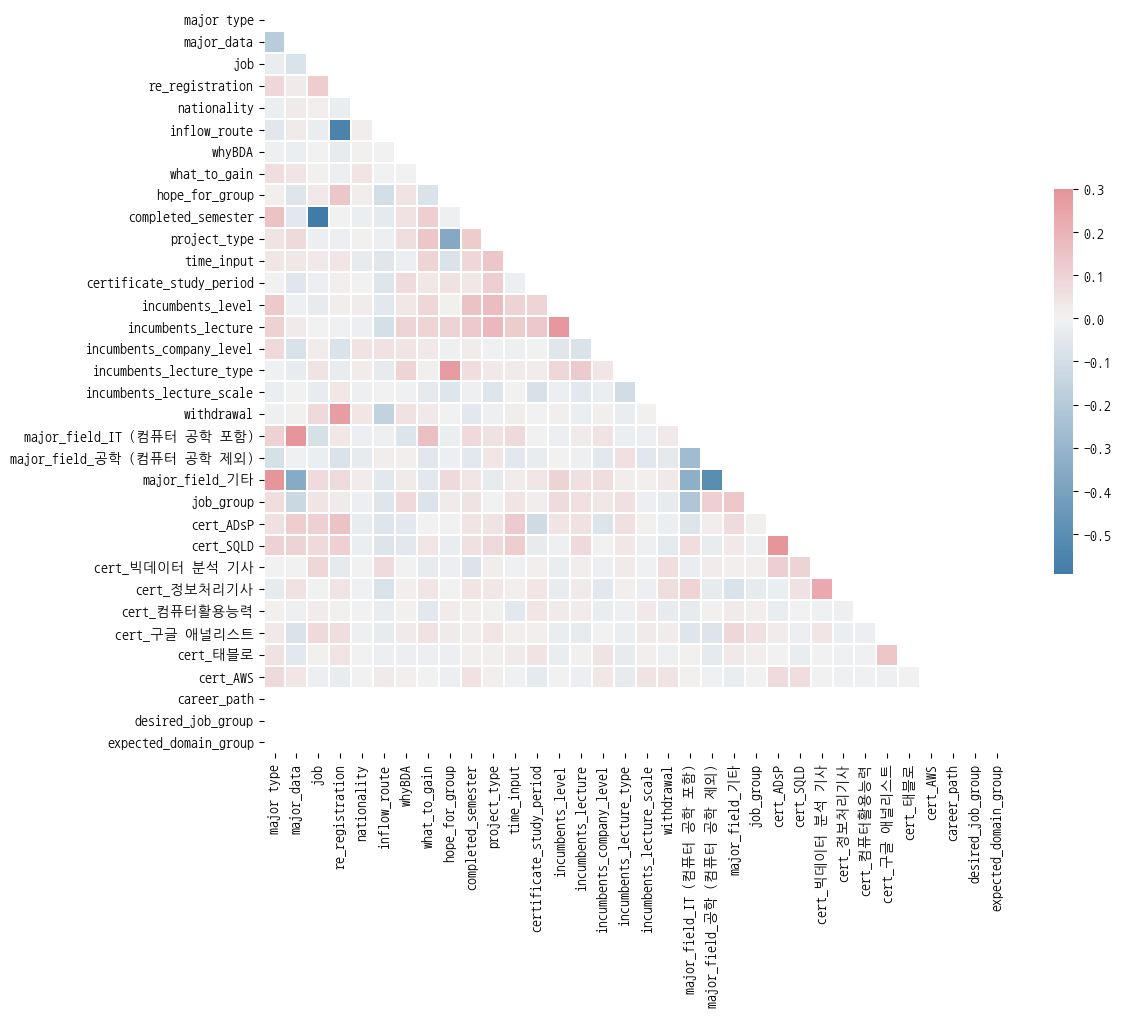

In [33]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔고딕코딩 폰트 경로 (보통 이 경로에 있음)
font_path = '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf'

# 폰트 프로퍼티 가져오기
fontprop = fm.FontProperties(fname=font_path).get_name()

plt.figure(figsize=(12,10))
corr_matrix = train2.corr()
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=0.3, center=0,
            square=True, linewidths=0.3, cbar_kws={'shrink' : 0.5})


plt.rcParams['axes.unicode_minus'] = False 
plt.rcParams['font.family'] = 'NanumGothicCoding'

In [81]:
train2.head()

,major type,major_data,job,re_registration,nationality,inflow_route,whyBDA,what_to_gain,hope_for_group,completed_semester,...,cert_SQLD,cert_빅데이터 분석 기사,cert_정보처리기사,cert_컴퓨터활용능력,cert_구글 애널리스트,cert_태블로,cert_AWS,career_path,desired_job_group,expected_domain_group
0,1,0,0,0,0,4,0,9,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,4,6,9,1,2,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,4,6,3,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,4,5,3,2,2,...,0,0,0,1,0,0,0,0,0,0
4,2,0,0,0,0,4,6,1,1,2,...,1,0,0,0,0,0,0,0,0,0


In [82]:
train2

,major type,major_data,job,re_registration,nationality,inflow_route,whyBDA,what_to_gain,hope_for_group,completed_semester,...,cert_SQLD,cert_빅데이터 분석 기사,cert_정보처리기사,cert_컴퓨터활용능력,cert_구글 애널리스트,cert_태블로,cert_AWS,career_path,desired_job_group,expected_domain_group
0,1,0,0,0,0,4,0,9,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,4,6,9,1,2,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,4,6,3,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,4,5,3,2,2,...,0,0,0,1,0,0,0,0,0,0
4,2,0,0,0,0,4,6,1,1,2,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,2,0,0,0,0,4,6,3,2,1,...,0,0,0,0,0,0,0,0,0,0
1052,1,1,0,1,0,1,6,3,2,2,...,0,0,1,0,0,0,0,0,0,0
1053,2,0,0,0,0,4,6,3,1,2,...,0,0,0,0,0,0,0,0,0,0
1054,1,0,0,0,0,4,0,3,2,2,...,0,0,0,0,1,0,0,0,0,0


In [21]:
train2.to_csv('train3.csv', index=False, encoding='utf-8-sig')

In [84]:
train2.columns

Index(['major type', 'major_data', 'job', 're_registration', 'nationality',
       'inflow_route', 'whyBDA', 'what_to_gain', 'hope_for_group',
       'completed_semester', 'project_type', 'time_input',
       'certificate_study_period', 'incumbents_level', 'incumbents_lecture',
       'incumbents_company_level', 'incumbents_lecture_type',
       'incumbents_lecture_scale', 'withdrawal', 'major_field_IT (컴퓨터 공학 포함)',
       'major_field_공학 (컴퓨터 공학 제외)', 'major_field_기타', 'job_group',
       'cert_ADsP', 'cert_SQLD', 'cert_빅데이터 분석 기사', 'cert_정보처리기사',
       'cert_컴퓨터활용능력', 'cert_구글 애널리스트', 'cert_태블로', 'cert_AWS', 'career_path',
       'desired_job_group', 'expected_domain_group'],
      dtype='object')

In [34]:
train_ch = pd.read_csv('./traindata_가공.csv')

In [35]:
train_ch

,sentence,키워드,사람기준_기대감
0,인원이 너무 많지 않아야 편하게 들을 수 있어서,규모,1
1,인원이 적어야 집중할 수 있고 질문 하기 쉽다.,상호작용,1
2,너무 소수인원은 조금 부담스럽고 너무 많은 인원은 집중도가 떨어질거같아서,분위기,0
3,너무 많은 인원이 있을 경우 집중도가 떨어질 거 같습니다.,분위기,0
4,많은 현직자분들의 이야기를 듣고싶어서,현직자,2
...,...,...,...
1057,1명의 현직자에게 집중하는 게 좋을 것 같아서,분위기,2
1058,"사람이 너무 많으면 집중할 수 없고, 너무 적으면 부담스러워서",분위기,0
1059,온라인은 사람이 너무 많으면 질문을 많이 할 수 없기에 적절한 규모가 필요하다고 생각,상호작용,1
1060,인원이 너무 적으면 예산이 부담될 것 같고 너무 많으면 집중이 안 될 것 같아서 중...,분위기,0


In [85]:
target = train2.pop("withdrawal")

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

train_X, test_X, train_y, test_y = train_test_split(train2, target, test_size=0.2, stratify=target, random_state=42)

In [87]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1, class_weight='balanced')
rf_clf.fit(train_X, train_y)

y_pred = rf_clf.predict(test_X)
accuracy = accuracy_score(test_y, y_pred)
report = classification_report(test_y, y_pred)

print("\n--- RandomForestClassifier 평가 ---")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)


--- RandomForestClassifier 평가 ---
Accuracy: 0.5236
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.77      0.50        65
           1       0.80      0.41      0.55       147

    accuracy                           0.52       212
   macro avg       0.59      0.59      0.52       212
weighted avg       0.67      0.52      0.53       212



In [88]:
rf_clf2 = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1, class_weight='balanced')
rf_clf2.fit(train_X, train_y)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_jobs=-1,
                       random_state=42)

In [89]:
y_pred = rf_clf2.predict(test_X)
accuracy = accuracy_score(test_y, y_pred)
report = classification_report(test_y, y_pred)

print("\n--- RandomForestClassifier 평가 ---")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)


--- RandomForestClassifier 평가 ---
Accuracy: 0.6321
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.18      0.24        65
           1       0.70      0.83      0.76       147

    accuracy                           0.63       212
   macro avg       0.51      0.51      0.50       212
weighted avg       0.58      0.63      0.60       212



In [90]:
rf_clfgrid = RandomForestClassifier(random_state=42)

In [91]:
from sklearn.model_selection import train_test_split, GridSearchCV

param_grid = {
    'max_depth': [11, 12, 13, 14, 15],
    'min_samples_split': [2, 3, 4]
}


# GridSearchCV 객체 생성 (5-겹 교차검증, 평가지표는 정확도)
grid_search = GridSearchCV(estimator=rf_clfgrid, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='accuracy', 
                           n_jobs=-1)

# 그리드 서치 시작 (시간이 다소 소요될 수 있습니다)
grid_search.fit(train_X, train_y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [11, 12, 13, 14, 15],
                         'min_samples_split': [2, 3, 4]},
             scoring='accuracy')

In [92]:
grid_search.best_params_

{'max_depth': 11, 'min_samples_split': 4}

In [93]:
rf_clf3 = RandomForestClassifier(
    n_estimators=100,        # 유지하거나 그리드서치에 포함되었다면 최적값 사용
    max_depth=11,            # 그리드서치 결과값
    min_samples_split=4,     # 그리드서치 결과값
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_clf3.fit(train_X, train_y)

RandomForestClassifier(class_weight='balanced', max_depth=11,
                       min_samples_split=4, n_jobs=-1, random_state=42)

In [94]:
y_pred = rf_clf3.predict(test_X)
accuracy = accuracy_score(test_y, y_pred)
report = classification_report(test_y, y_pred)

print("\n--- RandomForestClassifier 평가 ---")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)


--- RandomForestClassifier 평가 ---
Accuracy: 0.6038
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.38      0.37        65
           1       0.72      0.70      0.71       147

    accuracy                           0.60       212
   macro avg       0.54      0.54      0.54       212
weighted avg       0.61      0.60      0.61       212



In [95]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'max_depth': randint(10, 20),  # 2에서 9 사이의 정수를 랜덤하게 샘플링
    'min_samples_leaf': randint(1, 5), # 1에서 4 사이의 정수를 랜덤하게 샘플링
    'criterion': ['gini', 'entropy'] # 리스트 중에서 랜덤하게 선택
}

In [96]:
# RandomizedSearchCV 객체 생성 (총 20번의 탐색 시도)
rand_search = RandomizedSearchCV(estimator=rf_clfgrid,
                                 param_distributions=param_dist,
                                 n_iter=20, # 탐색 횟수
                                 cv=5,
                                 scoring='accuracy',
                                 n_jobs=-1,
                                 random_state=42) # 재현성을 위한 random_state

# 랜덤 서치 시작
rand_search.fit(train_X, train_y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f93e5ba6570>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f93ddb4fce0>},
                   random_state=42, scoring='accuracy')

In [97]:
rf_clf4 = RandomForestClassifier(
    n_estimators=100,        # 유지하거나 그리드서치에 포함되었다면 최적값 사용
    max_depth=12,            # 그리드서치 결과값
    min_samples_leaf=4,     # 그리드서치 결과값
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_clf4.fit(train_X, train_y)

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=4, n_jobs=-1, random_state=42)

In [98]:
y_pred = rf_clf4.predict(test_X)
accuracy = accuracy_score(test_y, y_pred)
report = classification_report(test_y, y_pred)

print("\n--- RandomForestClassifier 평가 ---")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)


--- RandomForestClassifier 평가 ---
Accuracy: 0.5377
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.42      0.36        65
           1       0.70      0.59      0.64       147

    accuracy                           0.54       212
   macro avg       0.50      0.50      0.50       212
weighted avg       0.58      0.54      0.55       212



In [100]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_clf4, train_X, train_y, cv=skf)
print("평균 정확도:", scores.mean())

평균 정확도: 0.6315088757396449


In [104]:
df = pd.read_csv("BDA_train_전처리.csv")
df.head()

,major type,major_data,inflow_route,whyBDA,time_input,desired_certificate,withdrawal,desired_job,major1_1,major1_2,...,what_to_gain_데이터 분석 역량,what_to_gain_공모전 경험,what_to_gain_인적 네트워크,what_to_gain_자격증 공부,what_to_gain_파이썬 실력,what_to_gain_기타,job_대학생,job_대학원생,job_직장인,job_취준생
0,2,False,0,0,1,1,1,2,0,7,...,0,0,0,0,0,0,True,False,False,False
1,2,False,0,1,0,1,1,1,0,0,...,0,0,0,0,0,0,True,False,False,False
2,2,True,0,1,0,1,1,0,0,7,...,1,0,0,0,0,0,True,False,False,False
3,2,True,0,2,0,1,0,0,0,7,...,1,0,0,0,0,0,True,False,False,False
4,2,False,0,1,0,1,1,0,0,0,...,0,1,0,0,0,0,True,False,False,False


In [113]:
df.dtypes

major type                    int64
major_data                     bool
inflow_route                  int64
whyBDA                        int64
time_input                    int64
desired_certificate           int64
desired_job                   int64
major1_1                      int64
major1_2                      int64
certificate_binary            int64
desired_career_path_mapped    int64
re_registration_mapped        int64
what_to_gain_프로젝트 경험          int64
what_to_gain_데이터 분석 역량        int64
what_to_gain_공모전 경험           int64
what_to_gain_인적 네트워크          int64
what_to_gain_자격증 공부           int64
what_to_gain_파이썬 실력           int64
what_to_gain_기타               int64
job_대학생                        bool
job_대학원생                       bool
job_직장인                        bool
job_취준생                        bool
dtype: object

In [106]:
y = df.pop("withdrawal")

In [107]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify=target, random_state=42)

In [111]:
rf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1, class_weight='balanced')
rf.fit(X_train, y_train)

pred_y = rf.predict(X_test)
accuracy = accuracy_score(y_test, pred_y)
report = classification_report(y_test, pred_y)

print("\n--- RandomForestClassifier 평가 ---")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)


--- RandomForestClassifier 평가 ---
Accuracy: 0.5566
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.31      0.30        65
           1       0.69      0.67      0.68       147

    accuracy                           0.56       212
   macro avg       0.49      0.49      0.49       212
weighted avg       0.56      0.56      0.56       212



In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X_train, y_train, cv=skf)

print("평균 정확도:", scores.mean())

평균 정확도: 0.6208720766413074


In [114]:
rf0 = RandomForestClassifier(random_state=42)
param_grid = {
    'max_depth': [11, 12, 13, 14, 15],
    'min_samples_split': [2, 3, 4]
}


# GridSearchCV 객체 생성 (5-겹 교차검증, 평가지표는 정확도)
grid_search = GridSearchCV(estimator=rf0, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='accuracy', 
                           n_jobs=-1)

# 그리드 서치 시작 (시간이 다소 소요될 수 있습니다)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [11, 12, 13, 14, 15],
                         'min_samples_split': [2, 3, 4]},
             scoring='accuracy')

In [115]:
grid_search.best_params_

{'max_depth': 11, 'min_samples_split': 3}

In [116]:
rf2 = RandomForestClassifier(
    n_estimators=100,        # 유지하거나 그리드서치에 포함되었다면 최적값 사용
    max_depth=11,            # 그리드서치 결과값
    min_samples_split=3,     # 그리드서치 결과값
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf2.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=11,
                       min_samples_split=3, n_jobs=-1, random_state=42)

In [117]:
pred_y2 = rf2.predict(X_test)
accuracy = accuracy_score(y_test, pred_y2)
report = classification_report(y_test, pred_y2)

print("\n--- RandomForestClassifier 평가 ---")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)


--- RandomForestClassifier 평가 ---
Accuracy: 0.5613
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.43      0.38        65
           1       0.71      0.62      0.66       147

    accuracy                           0.56       212
   macro avg       0.52      0.52      0.52       212
weighted avg       0.60      0.56      0.57       212



In [118]:
pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 20.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


train_X, test_X, train_y, test_y = train_test_split(train2, target, test_size=0.2, stratify=target, random_state=42)

In [120]:
from lightgbm import LGBMClassifier

# 모델 생성
lgbm_clf = LGBMClassifier(
    n_estimators=100,
    max_depth=11,
    min_child_samples=4,
    random_state=42,
    class_weight='balanced'  # 불균형 데이터일 경우
)

# 학습
lgbm_clf.fit(train_X, train_y)

# 예측
pred = lgbm_clf.predict(test_X)

# 평가
print(classification_report(test_y, pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 583, number of negative: 261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 844, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
              precision    recall  f1-score   support

           0       0.34      0.38      0.36        65
           1       0.71      0.67      0.69       147

    accuracy                           0.58       212
   macro avg       0.52      0.53      0.52       212
weighted avg       0.60      0.58      0.59       212



In [121]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_res, y_res = smote.fit_resample(train2, target)

In [ ]:
train2_X, test2_X, train2_y, test2_y = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)

In [123]:
test2_y.value_counts()

withdrawal
0    146
1    146
Name: count, dtype: int64

In [124]:
clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1, class_weight='balanced')
clf.fit(X_res, y_res)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_jobs=-1,
                       random_state=42)

In [126]:
pre = clf.predict(test2_X)
accuracy = accuracy_score(test2_y,pre)
report = classification_report(test2_y, pre)

print("\n--- RandomForestClassifier 평가 ---")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)


--- RandomForestClassifier 평가 ---
Accuracy: 0.9932
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       146
           1       1.00      0.99      0.99       146

    accuracy                           0.99       292
   macro avg       0.99      0.99      0.99       292
weighted avg       0.99      0.99      0.99       292

